# Here we show give an example of our full pipeline to extract data from timelapse.

### Load all relevant packages and connecting to your Drive
### * indicates not necessary to run pipeline


In [1]:
#@markdown #### Mount google drive and check that you are using high RAM and GPU resources.

from google.colab import drive
drive.mount('/content/drive')

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!
Not connected to a GPU


In [2]:
#@markdown ###*Install debugger
!pip install ipdb
import ipdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 51.9 MB/s 
     |████████████████████████████████| 1.6 MB 52.0 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=e862629723744466794830760f25a4545e40428e6442751df52574b29c6f1098
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


In [6]:
%%capture
Notebook_version = ['1.12']

#@markdown ####Install packages related to CARE

#Libraries contains information of certain topics. 
#For example the tifffile library contains information on how to handle tif-files.

#Here, we install libraries which are not already included in Colab.

!pip install tifffile # contains tools to operate tiff-files
!pip install csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.
!pip install wget
!pip install memory_profiler
!pip install fpdf
!pip install scikit-image==0.18
%load_ext memory_profiler

#Here, we import and enable Tensorflow 1 instead of Tensorflow 2.
%tensorflow_version 1.x

import sys
before = [str(m) for m in sys.modules]

import tensorflow 
import tensorflow as tf

print(tensorflow.__version__)
print("Tensorflow enabled.")

from __future__ import print_function, unicode_literals, absolute_import, division

# ------- Variable specific to CARE -------
from csbdeep.utils import download_and_extract_zip_file, plot_some, axes_dict, plot_history, Path, download_and_extract_zip_file
from csbdeep.data import RawData, create_patches 
from csbdeep.io import load_training_data, save_tiff_imagej_compatible
from csbdeep.models import Config, CARE
from csbdeep import data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



# ------- Common variable to all ZeroCostDL4Mic notebooks -------
import numpy as np
from matplotlib import pyplot as plt
import urllib
import os, random
import shutil 
import zipfile
from tifffile import imread, imsave
import time
import sys
import wget
from pathlib import Path
import pandas as pd
import csv
from glob import glob
from scipy import signal
from scipy import ndimage
from skimage import io
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
import matplotlib as mpl
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from astropy.visualization import simple_norm
from skimage import img_as_float32
from skimage.util import img_as_ubyte
from tqdm import tqdm 
from fpdf import FPDF, HTMLMixin
from datetime import datetime
import subprocess
from pip._internal.operations.freeze import freeze

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'

W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red

#Disable some of the tensorflow warnings
import warnings
warnings.filterwarnings("ignore")

print("Libraries installed")


# Check if this is the latest version of the notebook
Latest_notebook_version = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_ZeroCostDL4Mic_Release.csv")

if Notebook_version == list(Latest_notebook_version.columns):
  print("This notebook is up-to-date.")

if not Notebook_version == list(Latest_notebook_version.columns):
  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")

!pip freeze > requirements.txt

#Create a pdf document with training summary
def pdf_export(trained = False, augmentation = False, pretrained_model = False):
    """Create a pdf document with training summary for CARE."""
    
    # save FPDF() class into a  
    # variable pdf 
    #from datetime import datetime

    class MyFPDF(FPDF, HTMLMixin):
        pass

    pdf = MyFPDF()
    pdf.add_page()
    pdf.set_right_margin(-1)
    pdf.set_font("Arial", size = 11, style='B') 

    Network = 'CARE 2D'
    day = datetime.now()
    datetime_str = str(day)[0:10]

    Header = 'Training report for '+Network+' model ('+model_name+')\nDate: '+datetime_str
    pdf.multi_cell(180, 5, txt = Header, align = 'L') 

    # add another cell 
    if trained:
      training_time = "Training time: "+str(hour)+ "hour(s) "+str(mins)+"min(s) "+str(round(sec))+"sec(s)"
      pdf.cell(190, 5, txt = training_time, ln = 1, align='L')
    pdf.ln(1)

    Header_2 = 'Information for your materials and methods:'
    pdf.cell(190, 5, txt=Header_2, ln=1, align='L')

    all_packages = ''
    for requirement in freeze(local_only=True):
      all_packages = all_packages+requirement+', '
    #print(all_packages)

    #Main Packages
    main_packages = ''
    version_numbers = []
    for name in ['tensorflow','numpy','Keras','csbdeep']:
      find_name=all_packages.find(name)
      main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
      #Version numbers only here:
      version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

    cuda_version = subprocess.run('nvcc --version',stdout=subprocess.PIPE, shell=True)
    cuda_version = cuda_version.stdout.decode('utf-8')
    cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
    gpu_name = subprocess.run('nvidia-smi',stdout=subprocess.PIPE, shell=True)
    gpu_name = gpu_name.stdout.decode('utf-8')
    gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]
    #print(cuda_version[cuda_version.find(', V')+3:-1])
    #print(gpu_name)

    shape = io.imread(Training_source+'/'+os.listdir(Training_source)[1]).shape
    dataset_size = len(os.listdir(Training_source))

    text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(dataset_size*number_of_patches)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_size)+','+str(patch_size)+')) with a batch size of '+str(batch_size)+' and a '+config.train_loss+' loss function, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), csbdeep (v '+version_numbers[3]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

    if pretrained_model:
      text = 'The '+Network+' model was trained for '+str(number_of_epochs)+' epochs on '+str(dataset_size*number_of_patches)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_size)+','+str(patch_size)+')) with a batch size of '+str(batch_size)+' and a '+config.train_loss+' loss function, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). The model was re-trained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), csbdeep (v '+version_numbers[3]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

    pdf.set_font('')
    pdf.set_font_size(10.)
    pdf.multi_cell(190, 5, txt = text, align='L')
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.ln(1)
    pdf.cell(28, 5, txt='Augmentation: ', ln=0)
    pdf.set_font('')
    if augmentation:
      aug_text = 'The dataset was augmented by a factor of '+str(Multiply_dataset_by)+' by'
      if rotate_270_degrees != 0 or rotate_90_degrees != 0:
        aug_text = aug_text+'\n- rotation'
      if flip_left_right != 0 or flip_top_bottom != 0:
        aug_text = aug_text+'\n- flipping'
      if random_zoom_magnification != 0:
        aug_text = aug_text+'\n- random zoom magnification'
      if random_distortion != 0:
        aug_text = aug_text+'\n- random distortion'
      if image_shear != 0:
        aug_text = aug_text+'\n- image shearing'
      if skew_image != 0:
        aug_text = aug_text+'\n- image skewing'
    else:
      aug_text = 'No augmentation was used for training.'
    pdf.multi_cell(190, 5, txt=aug_text, align='L')
    pdf.set_font('Arial', size = 11, style = 'B')
    pdf.ln(1)
    pdf.cell(180, 5, txt = 'Parameters', align='L', ln=1)
    pdf.set_font('')
    pdf.set_font_size(10.)
    if Use_Default_Advanced_Parameters:
      pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
    pdf.cell(200, 5, txt='The following parameters were used for training:')
    pdf.ln(1)
    html = """ 
    <table width=40% style="margin-left:0px;">
      <tr>
        <th width = 50% align="left">Parameter</th>
        <th width = 50% align="left">Value</th>
      </tr>
      <tr>
        <td width = 50%>number_of_epochs</td>
        <td width = 50%>{0}</td>
      </tr>
      <tr>
        <td width = 50%>patch_size</td>
        <td width = 50%>{1}</td>
      </tr>
      <tr>
        <td width = 50%>number_of_patches</td>
        <td width = 50%>{2}</td>
      </tr>
      <tr>
        <td width = 50%>batch_size</td>
        <td width = 50%>{3}</td>
      </tr>
      <tr>
        <td width = 50%>number_of_steps</td>
        <td width = 50%>{4}</td>
      </tr>
      <tr>
        <td width = 50%>percentage_validation</td>
        <td width = 50%>{5}</td>
      </tr>
      <tr>
        <td width = 50%>initial_learning_rate</td>
        <td width = 50%>{6}</td>
      </tr>
    </table>
    """.format(number_of_epochs,str(patch_size)+'x'+str(patch_size),number_of_patches,batch_size,number_of_steps,percentage_validation,initial_learning_rate)
    pdf.write_html(html)

    #pdf.multi_cell(190, 5, txt = text_2, align='L')
    pdf.set_font("Arial", size = 11, style='B')
    pdf.ln(1)
    pdf.cell(190, 5, txt = 'Training Dataset', align='L', ln=1)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(29, 5, txt= 'Training_source:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = Training_source, align = 'L')
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(27, 5, txt= 'Training_target:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = Training_target, align = 'L')
    #pdf.cell(190, 5, txt=aug_text, align='L', ln=1)
    pdf.ln(1)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(22, 5, txt= 'Model Path:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
    pdf.ln(1)
    pdf.cell(60, 5, txt = 'Example Training pair', ln=1)
    pdf.ln(1)
    exp_size = io.imread('/content/TrainingDataExample_CARE2D.png').shape
    pdf.image('/content/TrainingDataExample_CARE2D.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
    pdf.ln(1)
    ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "ZeroCostDL4Mic: an open platform to simplify access and use of Deep-Learning in Microscopy." BioRxiv (2020).'
    pdf.multi_cell(190, 5, txt = ref_1, align='L')
    ref_2 = '- CARE: Weigert, Martin, et al. "Content-aware image restoration: pushing the limits of fluorescence microscopy." Nature methods 15.12 (2018): 1090-1097.'
    pdf.multi_cell(190, 5, txt = ref_2, align='L')
    if augmentation:
      ref_3 = '- Augmentor: Bloice, Marcus D., Christof Stocker, and Andreas Holzinger. "Augmentor: an image augmentation library for machine learning." arXiv preprint arXiv:1708.04680 (2017).'
      pdf.multi_cell(190, 5, txt = ref_3, align='L')
    pdf.ln(3)
    reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
    pdf.set_font('Arial', size = 11, style='B')
    pdf.multi_cell(190, 5, txt=reminder, align='C')

    pdf.output(model_path+'/'+model_name+'/'+model_name+"_training_report.pdf")


#Make a pdf summary of the QC results

def qc_pdf_export():
  """Make a PDF summary of the quality control results from CARE."""
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'CARE 2D'
  #model_name = os.path.basename(full_QC_model_path)
  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Development of Training Losses', ln=1, align='L')
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'Quality Control/QC_example_data.png').shape
  if os.path.exists(full_QC_model_path+'Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/13))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.', align='L')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="7" face="Courier New" >
  <table width=94% style="margin-left:0px;">"""
  with open(full_QC_model_path+'Quality Control/QC_metrics_'+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    image = header[0]
    mSSIM_PvsGT = header[1]
    mSSIM_SvsGT = header[2]
    NRMSE_PvsGT = header[3]
    NRMSE_SvsGT = header[4]
    PSNR_PvsGT = header[5]
    PSNR_SvsGT = header[6]
    header = """
    <tr>
      <th width = 10% align="left">{0}</th>
      <th width = 15% align="left">{1}</th>
      <th width = 15% align="center">{2}</th>
      <th width = 15% align="left">{3}</th>
      <th width = 15% align="center">{4}</th>
      <th width = 15% align="left">{5}</th>
      <th width = 15% align="center">{6}</th>
    </tr>""".format(image,mSSIM_PvsGT,mSSIM_SvsGT,NRMSE_PvsGT,NRMSE_SvsGT,PSNR_PvsGT,PSNR_SvsGT)
    html = html+header
    for row in metrics:
      image = row[0]
      mSSIM_PvsGT = row[1]
      mSSIM_SvsGT = row[2]
      NRMSE_PvsGT = row[3]
      NRMSE_SvsGT = row[4]
      PSNR_PvsGT = row[5]
      PSNR_SvsGT = row[6]
      cells = """
        <tr>
          <td width = 10% align="left">{0}</td>
          <td width = 15% align="center">{1}</td>
          <td width = 15% align="center">{2}</td>
          <td width = 15% align="center">{3}</td>
          <td width = 15% align="center">{4}</td>
          <td width = 15% align="center">{5}</td>
          <td width = 15% align="center">{6}</td>
        </tr>""".format(image,str(round(float(mSSIM_PvsGT),3)),str(round(float(mSSIM_SvsGT),3)),str(round(float(NRMSE_PvsGT),3)),str(round(float(NRMSE_SvsGT),3)),str(round(float(PSNR_PvsGT),3)),str(round(float(PSNR_SvsGT),3)))
      html = html+cells
    html = html+"""</body></table>"""

  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "ZeroCostDL4Mic: an open platform to simplify access and use of Deep-Learning in Microscopy." BioRxiv (2020).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- CARE: Weigert, Martin, et al. "Content-aware image restoration: pushing the limits of fluorescence microscopy." Nature methods 15.12 (2018): 1090-1097.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(full_QC_model_path+'Quality Control/'+QC_model_name+'_QC_report.pdf')


# Exporting requirements.txt for local run
!pip freeze > requirements.txt

after = [str(m) for m in sys.modules]
# Get minimum requirements file

#Add the following lines before all imports: 
#  import sys
#  before = [str(m) for m in sys.modules]

#Add the following line after the imports:
#  after = [str(m) for m in sys.modules]

from builtins import any as b_any

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

df = pd.read_csv('requirements.txt', delimiter = "\n")
mod_list = [m.split('.')[0] for m in after if not m in before]
req_list_temp = df.values.tolist()
req_list = [x[0] for x in req_list_temp]

# Replace with package name 
mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list] 
filtered_list = filter_files(req_list, mod_replace_list)


file=open('CARE_2D_requirements_simple.txt','w')
for item in filtered_list:
    file.writelines(item + '\n')

file.close()

import pandas as pd
from skimage import io,exposure, util
import matplotlib as plt
import numpy as np
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.1.2.30
!pip install cellpose 
from cellpose import models,io
# use_GPU = models.use_gpu()
from cellpose import plot


ValueError: ignored

In [4]:
#@markdown ####*This is only needed if above block throws an error with opencv (cv2)
# if error is thrown, comment out all lines below numpy install and run as separate block here

# !pip uninstall opencv-python-headless==4.5.5.62
# !pip install opencv-python-headless==4.1.2.30
# !pip install cellpose 
# from cellpose import models,io
# from cellpose import plot

In [5]:
#@markdown ####Load all other packages and general functions

# add various packages that aren't typically in colab
%%capture
!pip install mahotas
!pip install ortools
!pip install nd2reader

# load other packages.
import cv2
import dill
from functools import reduce
import mahotas
import matplotlib.pyplot as plt
import nd2reader
from numpy import genfromtxt
from scipy import ndimage as ndi
from skimage import color, feature, filters, io, measure, morphology, restoration, segmentation, exposure, restoration, data, exposure,transform
from skimage.feature import greycomatrix, greycoprops,hog
from skimage.segmentation import clear_border
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
import sys
import warnings


# import additional function related to connecting cells.
sys.path.insert(0,"/content/drive/MyDrive/FateTrack_Main/FateTrack_master/FateTrackScripts/")
from FT_connect_functions import *

# list of all features that are calculated using scikit image
featureColumns = ('label','area','filled_area','bbox','bbox_area', 'centroid','convex_area','eccentricity',
                      'solidity','convex_area','mean_intensity','min_intensity','filled_area',
                      'max_intensity','orientation','major_axis_length','minor_axis_length','euler_number',
                      'perimeter','extent','equivalent_diameter','feret_diameter_max','perimeter_crofton',
                      'moments_central','moments_hu','moments','moments_normalized',
                      'inertia_tensor','inertia_tensor_eigvals', 'intensity_image')

####!!!!####

# specify the segmentation mask and channel-based Image (will calculate fluoresence features as well).
def collectObjectTraits(segmentationsMask, channelImage, prefix="", time=0, addExtras=False, addNeighbors=False, maxsize=100):
    """Collect all features from a segmentation mask.

    Parameters
    __________
    segmentationsMask: array
      masks from segmentation, to be used to calculate features
    channelImage: array
      raw image
    prefix: str, default = ""
      prefix for features names when added to feature vector
    time: float, default = 0
      DESCRIPTION_HERE
    addExtras: bool, default = False
      whether to add additional object traits
    maxsize: int, default = 100
      size for padded image, passed into extraObjectTraits() if addExtras = true
    
    Returns
    _______
    final: dataframe
      features for all cells in image
    """
    image_props = pd.DataFrame(measure.regionprops_table(segmentationsMask, intensity_image=channelImage,properties=featureColumns)) # generate standard measurements with properties listed above.
    im_df = pd.DataFrame(image_props) # convert object to dataframe - is it not already a dataframe in the previous line?

    # extra features are added below (if specified)
    if (addExtras or addNeighbors):
      if (addExtras):
        additionProps = pd.DataFrame() # set up dataframe
        for object in range(im_df.shape[0]):
            tmpProps = extraObjectTraits(im_df['intensity_image'][object],maxsize=maxsize) # performs extra measurements on each cell.
            additionProps = additionProps.append(tmpProps) # appends extra features from each cell into single object.

        additionProps = additionProps.reset_index(drop=True) # reseting index allows for proper merging.
        im_df = pd.concat([im_df, additionProps], axis=1) # concatenate extra features into main feature frame.
      if (addNeighbors):
        im_df = getNeighborFeatures(im_df) # calculates neighbor features for each cell

    im_df = im_df.add_prefix(prefix) # add prefixes if they exist.
    im_df = im_df.rename(columns={prefix+'label':'label'})  # relabel with prefixes if they exist.
    im_df['time'] = time # specify time component.
    return(im_df)

 
def extraObjectTraits(intensityImage, maxsize=100):
    """Function to load in additional object traits.

    Parameters
    __________
    intensityImage: 2d array
      raw image
    maxsize: int, default = 100
      size for padded image
    
    Returns
    _______
    dataframe
      extra image features
    """
    im_stretched = mahotas.stretch(intensityImage) # linear stretch of intensities from 0 to 255

    zernike = mahotas.features.zernike(im_stretched, radius=20, degree=8, cm=mahotas.center_of_mass(im_stretched))
    zern_df = pd.DataFrame(zernike).T
    zern_df.columns = ['zern_'+ sub for sub in list(map(str,zern_df.columns))]

    haralick = mahotas.features.haralick(im_stretched,return_mean=True)
    hara_df = pd.DataFrame(haralick).T
    hara_df.columns = ['hara_'+ sub for sub in list(map(str,hara_df.columns))]
    width,height = np.shape(im_stretched)

    h1 = int(np.floor((maxsize-height)/2))
    h2 = int(np.ceil((maxsize-height)/2))
    w1 = int(np.floor((maxsize-width)/2))
    w2 = int(np.ceil((maxsize-width)/2))
    padIm =(np.pad(im_stretched,pad_width=((w1,w2),(h1,h2)),mode='constant'))

    hog_fd = hog(padIm, orientations=20, pixels_per_cell=(25, 25), cells_per_block=(2, 2), visualize=False, multichannel=False,feature_vector=True) # histogram of oriented gradients
    hog_df = pd.DataFrame(hog_fd).T
    hog_df.columns = ['hog_'+ sub for sub in list(map(str,hog_df.columns))]

    return(pd.concat([hog_df, hara_df,zern_df], axis=1))

def getNeighborFeatures(im2_df):
  """ Function to calculate neighborhood features.

  Parameters
  __________
  sub_tab: dataframe
    contains centroid coordinates for each nucleus

  Returns
  _______
  im2_df: dataframe
    contains neighborhood features for each nucleus
  """
  sub_tab = im2_df[["centroid-0", "centroid-1"]] # df of centroids
  nn = NearestNeighbors(n_neighbors = sub_tab.shape[0], radius = 50) # create nearest neighbor model
  nn.fit(sub_tab) # find the nearest neighbors
  nn_dist, nn_ind = nn.radius_neighbors(sub_tab) # find distances to each other nucleus and the indices of the neighbors in 50px radius

  # look at distances between every pair of nuclei and take the minimum
  # must calculate desparately from nn to account for having no neighbors in 50px radius
  mindist = []
  dist = euclidean_distances(sub_tab) # Euclidean distances between all centroids
  for i in range(dist.shape[0]):
    dist_i = dist[i]
    dist_i = dist_i[dist_i > 0] # filter out the nucleus itself
    mindist.append(min(dist_i)) # add the minimum distance to list
  im2_df["mindist"] = mindist # append min distances to the feature frame
  
  # treat every nucleus as a point (centroid), count all other nuclei within given radius
  nearby = []
  for i in range(nn_ind.shape[0]):
      nearby.append(nn_ind[i].shape[0]) # find the number of nuclei within 50px radius
  im2_df["nearby.cells"] = nearby

  ## nearest neighbor features - can be anything from the full list of features (but might want to avoid the inertia features)
  colOfInterest = ["area", "eccentricity", "solidity", "convex_area"
                ,"orientation", "major_axis_length","minor_axis_length", "perimeter", "extent"]
  for col in colOfInterest:
    colMin = []
    colMax = []
    for i in range(nn_ind.shape[0]):
      if nn_ind[i].shape[0] == 0:
        colMin.append(im2_df.loc[i, col])
        colMax.append(im2_df.loc[i, col])
      else:
        min_all = sys.maxsize
        max_all = 0
        for j in nn_ind[i]:
          feat = im2_df.loc[j, col]
          if feat < min_all:
            min_all = feat
          if feat > max_all:
            max_all = feat
        colMin.append(min_all)
        colMax.append(max_all)
    im2_df["nearby_" + col + "_min"] = colMin
    im2_df["nearby_" + col + "_max"] = colMax

  return im2_df

#Often images are too large to process with colab, it helps to break them into smaller trucks for processing.
def subDivideImage(imageFilename,div = 4):
  """Split image into smaller blocks for processing. This function is not used in processing but is helpful for your own use.

  Parameters
  __________
  imageFilename: str
    filename of larger image
  div: int
    number of divisions of the image along one dimension, total number of blocks will be div^2

  Returns
  _______
  imageList: list of 2d arrays
    list of the smaller images
  """
  image=io.imread(imageFilename, plugin="pil") # read in image file
  newDim = int(np.floor(np.min([image.shape[1],image.shape[2]])/div)) # determine the image dimenion for a given subdivision dize.
  imageList = [] 
  for i in range(div):   # break image into parts and save each subdivided image into a list.
    for ii in range(div):
      tmp = util.img_as_uint(image[:,(i*newDim):((i+1)*newDim),(ii*newDim):((ii+1)*newDim)])
      imageList.append(tmp)
  return(imageList)

# older function used to process images as above^ but for ND2s.
def subDivideND2(image,div = 4):
  """Split nd2 image into smaller blocks for processing. This function is not used in processing but is helpful for your own use.

  Parameters
  __________
  imageFilename: nd2 object
    nd2 image, already loaded
  div: int
    number of divisions of the image along one dimension, total number of blocks will be div^2

  Returns
  _______
  imageList: list of 2d arrays
    list of the smaller images
  """
  newDim = int(np.floor(np.min([image.shape[1],image.shape[2]])/div))
  imageList = []
  for i in range(div):
    for ii in range(div):
      tmp = util.img_as_uint(image[:,(i*newDim):((i+1)*newDim),(ii*newDim):((ii+1)*newDim)])
      imageList.append(tmp)
  return(imageList)
# defualt dettings use GPU and a nuclear diameter set to 21 pixels.
def imAdjust(I,low_in,high_in,low_out,high_out,gamma=1):
    
    # Similar to imadjust in MATLAB.
    # Converts an image range from [low_in,high_in] to [low_out,high_out].
    # The Equation of a line can be used for this transformation:
    #   y=((high_out-low_out)/(high_in-low_in))*(I-low_in)+low_out
    # However, it is better to use a more generalized equation:
    #   y=((I-low_in)/(high_in-low_in))^gamma*(high_out-low_out)+low_out
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.

    return (((I - low_in) / (high_in - low_in)) ** gamma) * (high_out - low_out) + low_out


def generateDisplacement(image1,image2):
    """General function to generate the displacement vector between two images using phase cross correlation.

    Parameters
    __________
    image1 : array
      reference image
    image2 : array
      moving image
    
    Returns
    _______
    ndarray
      displacement in y in pixels, displacement in x in pixels
    """
    shift_vector = registration.phase_cross_correlation(image1,image2) # generates displacements, from skimage
    return(shift_vector[0])



# default settings use GPU and a nuclear diameter set to 21 pixels.
def segmentNuclei(imageList, modelCellpose=None, useGPU = True, flowThreshold= 0.5, cellProbabilityThreshold= 1.0,nuclearDiameter= 21.0, channels= [0,0]):
  """Wrapper function to segment images using cellpose.

  Parameters
  __________
  imageList : list
    list of images to segment
  modelCellpose : string, default = None
    Cellpose model to use, specified above
  useGPU : bool, default = True
    whether to use GPU
  flowThreshold : float, default = 0.5
    flow error threshold for cellpose
  cellProbabilityThreshold : float, default = 1.0
    DESCRIPTION HERE
  nuclearDiameter : float, default = 21.0
    average nuclear diameter for cellpose
  channels : list, default = [0, 0]
    list of channels, either of length 2 or of length number of images by 2. 
    First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue). 
    Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue).
    [0, 0] for grayscale images.
  
  Returns
  _______
  masks : list of 2d arrays
    masks
  """
  if (modelCellpose != None): # use provided model for Cellpose
    masks, flows, styles = modelCellpose.eval(imageList, diameter=nuclearDiameter, flow_threshold=flowThreshold,
                                          cellprob_threshold=cellProbabilityThreshold, channels=channels)
  else:
    modelCellpose = models.Cellpose(model_type='nuclei', gpu=useGPU) # use nucleus model if none provided
    masks, flows, styles, diams = modelCellpose.eval(imageList, diameter=nuclearDiameter, flow_threshold=flowThreshold,
                                          cellprob_threshold=cellProbabilityThreshold, channels=channels)

  return(masks)


def generateConnections(frame_0, frame_1, shiftVector,time=0, allowSplitting=True):
  """Generate connections between cells in consecutive timelapse frames.

  Parameters
  __________
  frame_0: dataframe
      A dataframe containing the information (cell IDs, positions, sizes, etc...) for all cells at current frame.
  frame_1: dataframe
      A dataframe containing the information (cell IDs, positions, sizes, etc...) for all cells at next frame.
  shiftVector: array
      An array contianing the overall displacement vector between two frames.
  time: int, default = 0
    timepoint of initial frame
  allowSplitting: bool, default = True
    whether to allow for dividing cells

  Returns
  _______
  final: dataframe
    connections
  
  """
  t01, candies, costMatrix1 = getCostMatrix(frame_0, frame_1,shiftVec =shiftVector) # potential future location for each cell, candidates for future cells, cost matrix for each of those candidates
  if (allowSplitting):
    mitosisCandidates =getMitosisCandidates(CandidateFrame=candies,FeatureFrame_t0=t01,FeatureFrame_t1=frame_1) # find candidates for future cells if splitting is allowed
    if (mitosisCandidates.shape[0]>1):
        mitosisConnections = np.unique(np.append(np.delete(mitosisCandidates, 1, 1),
                                                  np.delete(mitosisCandidates, 2, 1),axis=0),axis=0) # WHAT DOES THIS LINE DO
        for i in range(mitosisConnections.shape[0]):
            costMatrix1[mitosisConnections[i,1],mitosisConnections[i,0]] = (costMatrix1[mitosisConnections[i,1],mitosisConnections[i,0]]/2)

        mitosisCandidateNodes = np.unique(mitosisConnections[:,0])

        FinFrame = solveMinCostFlow(CostMatrix=costMatrix1, mitosisCands=mitosisCandidateNodes)
    else:
        FinFrame = solveMinCostFlow(CostMatrix=costMatrix1,mitosisCands=[])
  else:
    FinFrame = solveMinCostFlow(CostMatrix=costMatrix1,mitosisCands=[])

  final = formatFinalConnections(Connections=FinFrame,FeatureFrame_t0=t01,FeatureFrame_t1=frame_1,timept_0=str(time), timept_1=str(time+1))
  return(final)

def solveMinCostFlowFixed(CostMatrix,mitosisCands):
    """Solves the global minimum cost by assigning cells in frame n to counterparts in frame n+1.

    Parameters
    __________
    CostMatrix: array
      An array containg the cost of connecting a cell in frame n to an allowed cell in frame n+1.
    mitosisCands: list
      A list containing all cells that can possibly divide between two frames as determined by properties of nuclei.

    Returns
    _______
    FinalFrame: dataframe
      A dataframe that gives the start cell(node) and end cell(node) after solving the min cost flow. 
    """
    global openingCost, closingCost

    t0Nodes = np.array(range(CostMatrix.shape[1]))+1  # generate array of numbers designating all start nodes (from 1 to n, where n is number of start nodes)
    t1Nodes = np.array(range(CostMatrix.shape[1],np.sum(CostMatrix.shape)))+1 # generate array of numbers designating all end nodes (from n+1 to n+m+1, where n is number of start nodes and m is number of n nodes)

    # need to generate all possible connections. Shape of network resembles.
    #      ---1-----4---
    #.    /     \ /     \
    #    0----2--X--5----7
    #     \     / \     /
    #.     ---3-----6---
    # Where 0 is the source, and 7 is the sink.

    # We begin to build the structure for computing the min cost flow.

    # Give all possible connections by creating all start nodes (including repeats)
    start_nodes = np.concatenate((np.repeat([0],np.sum(CostMatrix.shape)), # all connections to source node
                                  (np.nonzero(CostMatrix))[1]+1, # all connections from t0 to t1
                                  t0Nodes,t1Nodes # all connections to sink node
                                 )).tolist()
    
    # Give all possible connections by creating all start end (including repeats)
    end_nodes = np.concatenate((t0Nodes,t1Nodes, # all connections to source node
                                np.nonzero(CostMatrix)[0]+int(CostMatrix.shape[1])+1, # all connections from t0 to t1
                                np.repeat([np.sum(CostMatrix.shape)+1],np.sum(CostMatrix.shape)) # all connections to sink node
                                 )).tolist()
    
    # Generate a list of costs for all connections using the cost matrix. The cost of going from the source node and to sink node low (1).
    costs = np.concatenate((np.repeat(1,CostMatrix.shape[1]), # all connections to source node
                            np.repeat(openingCost,CostMatrix.shape[0]),
                            CostMatrix[CostMatrix!=0], # all connections from t0 to t1
                            np.repeat(closingCost,CostMatrix.shape[1]), # all connections to sink node
                            np.repeat(1,CostMatrix.shape[0]) # all connections to sink node
                            )).tolist()

    # Generate the capacities for each node.
    nodeCaps = np.concatenate((t0Nodes,t1Nodes),axis=0)
    nodeCaps = np.vstack((nodeCaps, np.repeat(1,len(nodeCaps)))).T

    # If the node is a  mitosis candidate (can generate two connections), then we replace the capacity with a value of 2.
    if(len(mitosisCands)>0):
        nodeCaps[np.searchsorted(nodeCaps[:,0],mitosisCands+1),1]=2

    # Creates the capacities list.
    capacities = np.concatenate((nodeCaps[:,1], # all connections to source node
                                 np.repeat(1,np.sum(CostMatrix[CostMatrix!=0].shape)),# all connections from t0 to t1
                                np.repeat(1,np.sum(CostMatrix.shape)) # all connections to sink node
                                )).tolist()

    # Generate the supplies at the source node and sink node. We do not allow for sources or sinks outside of the 0th and (n+m+1)th nodes.
    supply_amount = np.min([CostMatrix.shape[1],CostMatrix.shape[0]])#np.max([CostMatrix.shape[0],CostMatrix.shape[1]])
    supplies = np.concatenate(([supply_amount],np.repeat(0,np.sum(CostMatrix.shape)),[-1*supply_amount])).tolist()


    min_cost_flow = pywrapgraph.SimpleMinCostFlow() # creates the min cost flow object.

    # Add each arc within the min cost flow object. 
    # The arc subobject contain a start and end node, a capacity, and a cost.
    for i in range(len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i],capacities[i], int(costs[i]))

    # Add the supply to each node.
    for i in range(len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])


    ArcFrame = pd.DataFrame() # creates a dataframe object for dinal export.

    # Find the minimum cost flow between node 0 and node 4.
    if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
        print('Minimum cost:', min_cost_flow.OptimalCost())
        for i in range(min_cost_flow.NumArcs()):
            cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i) # cost is defined as the flow (number of units across a connection) * the cost of the connection.

            ArcFrame = ArcFrame.append(pd.DataFrame([min_cost_flow.Tail(i),
              min_cost_flow.Head(i),
              min_cost_flow.Flow(i),
              min_cost_flow.Capacity(i),
              cost]).T)
    else:
        print('There was an issue with the min cost flow input.')

    ArcFrame = ArcFrame.rename(columns={0:'start',1:'end',2:"Flow",3:"Capacity",4:"Cost"}) #rename columns
    FinalFrame = ArcFrame.loc[ArcFrame["Flow"]!=0,] #remove all arcs that are unused.
    FinalFrame = FinalFrame[(FinalFrame["start"]!=0)&(FinalFrame["end"]!=(np.sum(CostMatrix.shape)+1))] #remove all arcs that start with the source and the sink.
    FinalFrame['end']=(FinalFrame['end']-int(CostMatrix.shape[1])-1)
    FinalFrame['start']=(FinalFrame['start']-1) # rename the nodes 
    FinalFrame = FinalFrame.reset_index(drop=True) # reset the index so the frames last index is the number of rows.
    return(FinalFrame)

def getCostMatrix(FeatureFrame_t0, FeatureFrame_t1, shiftVec):
    """Generate the cost matrix for all possible cells in current frame to cells in next frames.

    Parameters
    __________
    FeatureFrame_t0: dataframe
      A dataframe containing the information (cell IDs, positions, sizes, etc...) for all cells at current frame.
    FeatureFrame_t1: dataframe
      A dataframe containing the information (cell IDs, positions, sizes, etc...) for all cells at next frame.
    shiftVec: array
      An array contianing the overall displacement vector between two frames.

    Returns
    _______
    FeatureFrame_t0: dataframe
      A dataframe with updated information for the current time.
    CandidateMtx: array
      A matrix that associated any current cell with any possible connection at the next time point.
    costMatrix: array
      A matrix listing all the costs in connecting a current cell with a future cell.
    """
    global track_frameExpCoeff, costIntCoefficient, costSizeCoefficient, costPositionCoefficient


#### -> LAILA 
    FeatureFrame_t0 = expandBoundBox(FeatureFrame_t0, expansion = track_frameExpCoeff) # calculate the bound box to determine potential future cells.
    FeatureFrame_t0 = futureBoundBox(FeatureFrame_t0, shiftVector=shiftVec) # calculate the bound box when you take into account the shift between the two frames.
    CandidateMtx = genCandidateNodes(FeatureFrame_t0,FeatureFrame_t1) # generate all possible future cells for each current cell.
    FeatureFrame_t0 = expectedLocation(FeatureFrame_t0, shiftVector=shiftVec) # generate potential future locations for each cell.
    deltaPosition = getDifference(FeatureFrame_t0,FeatureFrame_t1,"position") # find the difference in position between each current cell and all possible future cells. This weighs into cost.
    deltaArea = getDifference(FeatureFrame_t0,FeatureFrame_t1,"area") # find the difference in area between each current cell and all possible future cells. This weighs into cost.

    costMatrix = ((costSizeCoefficient*(deltaArea)+costPositionCoefficient*(deltaPosition))*CandidateMtx) #Use a linear combination of differences in current and future cellular properties to calculate cost of each connection.
    return((FeatureFrame_t0,CandidateMtx,costMatrix))


def generateConnectionsFixed(frame_0, frame_1, shiftVector,time=0, allowSplitting=True):
  t01, candies, costMatrix1 = getCostMatrix(frame_0, frame_1,shiftVec =shiftVector)
  if (allowSplitting):
    mitosisCandidates =getMitosisCandidates(CandidateFrame=candies,FeatureFrame_t0=t01,FeatureFrame_t1=frame_1)
    if (mitosisCandidates.shape[0]>1):
        mitosisConnections = np.unique(np.append(np.delete(mitosisCandidates, 1, 1),
                                                  np.delete(mitosisCandidates, 2, 1),axis=0),axis=0)

        for i in range(mitosisConnections.shape[0]):
            costMatrix1[mitosisConnections[i,1],mitosisConnections[i,0]] = (costMatrix1[mitosisConnections[i,1],mitosisConnections[i,0]]/2)

        mitosisCandidateNodes = np.unique(mitosisConnections[:,0])

        FinFrame = solveMinCostFlow(CostMatrix=costMatrix1, mitosisCands=mitosisCandidateNodes)
    else:
        FinFrame = solveMinCostFlow(CostMatrix=costMatrix1,mitosisCands=[])
  else:
    FinFrame = solveMinCostFlowFixed(CostMatrix=costMatrix1,mitosisCands=[])
    
  final = formatFinalConnections(Connections=FinFrame,FeatureFrame_t0=t01,FeatureFrame_t1=frame_1,timept_0=str(time), timept_1=str(time+1))
  return(final)

def save_object(obj, filename):
    """Save a FateTrack object to a .pkl file.

    Parameters
    __________
    obj: FateTrack object.
      The filename for the .pkl object.
    filename: str
      The filename for the .pkl object.
    """
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        dill.dump(obj, output)

def load_object(filename):
    """Load a pickle object.

    Parameters
    __________
    filename: str
      The filename for the .pkl object.

    Returns
    _______
    tmp: FateTrack
      The FateTrack object.
    """
    with open(filename, 'rb') as red:  # Overwrites any existing file.
        tmp = dill.load(red)
    return(tmp)

def templateCall(smallerImage, largerImage):
  """Match cells between timelapse and HCR rounds.

  Parameters
  __________
  smallerImage: array
    smaller of the images to match
  largerImage: array
    larger of the images to match

  Returns
  _______
  newDims0: tuple of int
    new y min coordinate, new y max coordinate
  newDims1: tuple of int
    new x min coordinate, new x max coordinate
  matchGrid.argmax(): cross correlation score where template is matched
  """
  matchGrid = cv2.matchTemplate(smallerImage.astype('float32'),largerImage.astype('float32'),cv2.TM_CCOEFF_NORMED) # find smaller (template) image in larer image
  newImSpot = np.unravel_index(matchGrid.argmax(),matchGrid.shape) # find where the template matches best
  newDims0 = newImSpot[0], newImSpot[0]+smallerImage.shape[0] # y coordinates
  newDims1 = newImSpot[1], newImSpot[1]+smallerImage.shape[1] # x coordinates
  return([newDims0,newDims1],np.amax(matchGrid))


def getDilatedMasks(maskImage, round="Rd1",dilationPixels=3):
  """ Finds dilated masks.

  Parameters
  __________
  maskImage: ndarray
    image of masks
  round: str, default = "Rd1"
    which HCR rounds the masks are being dilate dfor, used as a prefix in final dataframe
  dilationPixels: float, default = 3
    number of pixels to dilate masks by

  Returns
  _______
  dilationMasks: ndarray
    dilated masks
  points_frame: dataframe
    contains the pre-dilated and post-dilated labels for the masks
  """
  points_frame = pd.DataFrame(measure.regionprops_table(maskImage, properties=['label','centroid'])) # get label and centroid based on masks
  pointList = np.array(points_frame.iloc[:,-2:].astype(int)) # save the centroids, rounded off to integers, in n x 2 array
  masks=morphology.dilation((maskImage>0),morphology.disk(dilationPixels)) # dilate the masks
  secmask = np.zeros(masks.shape, dtype=bool) # make array of False in shape of image
  secmask[tuple(pointList.T)] = True # change to True where the centroids are located
  secmaskDil = morphology.dilation(secmask,morphology.square(3)) # create square of size 3 around the each centroid
  markers, _ = ndi.label(secmaskDil) # numbers each nucleus
  dilationMasks = segmentation.watershed( -secmask.astype(int), markers, mask=(masks>0)) # perform watershed on the nuclei

  points_frame['dilated_label'] = [dilationMasks[pointList[x,0],pointList[x,1]] for x in range(pointList.shape[0])] # finds the dilated label corresponding to each centroid
  points_frame = points_frame.rename(columns={'label' : 'orig_label'}) # renames the label column to indicate that it is the orignal (pre-dilated) label
  points_frame = points_frame.drop(columns=['centroid-0', 'centroid-1'])
  points_frame = points_frame.add_prefix(str(round)+"_") # adds round prefix to the labels
  return(dilationMasks,points_frame)

def quantiles(regionmask, intensity):
    return np.percentile(intensity[regionmask], q=(10, 25, 50, 75, 90))

def measureIntProps(maskMtx,channel,channelImage):
    """ Measure HCR fluorescence intensities in all channels.

    Parameters
    __________
    maskMtx: ndarray
      dilated masks
    channel: str
      channel in which intensity is being calculated
    channelImage: ndarray
      image for that channel

    Returns
    _______
    props: dataframe
      contains intensity properties for the channel
    """
    listprops = ('label','centroid','filled_area','min_intensity','mean_intensity','max_intensity') # intensity properties to calculate
    props = measure.regionprops_table(maskMtx, intensity_image=channelImage, properties=listprops,extra_properties = (quantiles,)) # calculates the properties and the intensity quantiles
    props = pd.DataFrame(props) # convert to dataframe
    props['sum_intensity'] =  props['filled_area'] * props['mean_intensity'] # integrate intensity over the image (mean)
    props['mean_intensity'] = props['mean_intensity']
    props = props.add_prefix(channel+'_') # add the channel name as a prefix to each of the properties in the dataframe columns
    props = props.rename(columns={channel+"_label": "label",
                                  channel+"_centroid-0": "centroid-0",
                                  channel+"_centroid-1": "centroid-1"}) # rename the label columns to have the channel
    return(props)
    

def getCellTypes(meas_df, muc2_thresh = 0.002, chga_thresh = 0.002, clu_thresh = 0.002, aldob_thresh = 0.002, lyz1_thresh = 0.002) :
  """ Determines cell types using laplacian to threshold.

  Parameters
  __________
  meas_df: dataframe
    contains nuclear intensity and laplacian measurements in all channels
  muc2_thresh: float, default = 0.002
    threshold density for histogram bins, cells with laplacian values in bins below this density are considered goblet cells
  chga_thresh: float, default = 0.002
    threshold density for histogram bins, cells with laplacian values in bins below this density are considered enteroendocrine cells
  clu_thresh: float, default = 0.002
    threshold density for histogram bins, cells with laplacian values in bins below this density are considered Clu-positive cells
  aldob_thresh: float, default = 0.002
    threshold density for histogram bins, cells with laplacian values in bins below this density are considered enterocytes
  lyz1_thresh: float, default = 0.002
    threshold density for histogram bins, cells with laplacian values in bins below this density are considered Paneth cells

  Returns
  _______
  meas_df: dataframe
    measurement dataframe with column appended with celltype labels
  """
  meas_df['celltype'] = "none" # add a column for celltype annotations
  thresh_density = {'1_YFP' : muc2_thresh, '1_CY5' : chga_thresh, '2_CY3' : clu_thresh, '2_YFP' : aldob_thresh, '2_CY5' : lyz1_thresh}
  # for each channel name
  for channel in thresh_density :
    col_string = 'lp_Rd' + channel + '_mean_intensity'
    mean_lp = meas_df[col_string] # get the column with the mean laplacian values for that channel
    hist, bin_edges = np.histogram(mean_lp, bins = np.arange(0, np.max(mean_lp) + 0.002, 0.002)) # create a histogram of laplacian values
    lp_thresh = hist / len(mean_lp) < thresh_density.get(channel) # determine whether the density is below the threshold
    # find the first bin that dips below the density threshold
    thresh_bin = 500
    for i in range(len(lp_thresh)) :
      if lp_thresh[i] :
        thresh_bin = i
        break
    if thresh_bin < 500 : # if there are bins below the threshold
      cutoff = bin_edges[thresh_bin] # determine cutoff laplacian value
      # append the label for this channel to the label column if its laplacian is above the set value
      for i in range(len(mean_lp)) :
        if mean_lp[i] > cutoff :
          if meas_df['celltype'][i] == "none" :
            meas_df['celltype'][i] = [channel]
          else :
            meas_df['celltype'][i].append(channel)
  return meas_df

ImportError: ignored

In [6]:
#@markdown #### Load FateTrack class and FateTrack specific functions 
from datetime import datetime

class FateTrack:
  """Contains raw and transformed images, features, and intensity measurements for one block of one image (sample).

  Attributes
  __________
  block : int
    the assigned number of block when the field of view is divided
  divDimension : int
    number of divisions to perform on the image in each dimension (e.g. 3 means each row and column would be split by 3, for 9 blocks)
  finalIDs : dataframe
    contains the IDs for each nucleus at each timepoint and HCR rounds, with dilation
  HCR1file : str
    the filename and path to the 1st round HCR nd2 file
  HCR2file : str
    the filename and path to the 2nd round HCR nd2 file
  HCR_channelList: array of str
    channel names in HCR nd2 files
  HCR_measurements : dataframe
    image-normalized mean and percentile measurements for round 1 and round 2 HCR images, along with cell type annotation
  HCR_Rd1_DAPI_mask: array of uint8
    matrix of segmentation mask from HCR Rd1 DAPI channel
  HCR_Rd1_images : list of array of float
    HCR Rd1 images after alignment
  HCR_Rd1_mCherry_mask : array of uint16
    matrix of segmentation mask from HCR Rd1 mCherry channel (A594)
  HCR_Rd2_DAPI_mask : array of uint8
    matrix of segmentation mask from HCR Rd2 DAPI channel
  HCR_Rd2_images : list of array of float
    HCR Rd2 images after alignment
  HCR1toHCR2_coords : tuple of float
    coordinates in large HCR2 image that correspond to top left corner of HCR1 image
  HCR1toHCR2_crosscor : float
    cross-correlation score for matching HCR1 to HCR2 image
  keepTrailingFrames : str
    number of frames to keep from the trailing end, for example, 9 would mean to keep the final 9 frames of the timelapse
  masterDF: dataframe
    contains RLG IDs, Master IDs, and centroids at all timepoints and HCR (raw and dilated)
  nuclearChannel : str
    name of the channel to for segmentation of the nuclear timelapse, e.g. ‘A594’
  num_frames : int
    number of frames in the timelapse series
  outPath : str
    path to folder for output of component files and .pkl file
  sample : str
    name of the sample and the output folder
  timelapse_connections : list of dataframes
    each dataframe shows the connection between nuclear masks between imaging rounds
  timelapse_displacements : list of arrays
    each array has 2-elements showing the translational shift between frames in the timelapse
  timelapse_nucFluor_features : list of dataframes
    each dataframe gives the features of fluorescence nucleus at a given time point
  timelapse_nuclear_images: list of arrays of float
    each item in list is a restored fluorescent image in the timelapse series
  timelapse_raw_nuclear_images : list of arrays of float
    each item in list is a raw (unrestored) fluorescent image in the timelapse series
  timelapse_nuclear_masks : list of arrays of int
    each item in list is a segmentation mask from cellpose corresponding to timelapse fluorescence image
  timelapse_nucPhase_features : list of dataframes
    each dataframe gives the features of brightfield nucleus at a given time point
  timelapse_phase_images : list of arrays of float
    each item in list is a brightfield/phase image in the timelapse series
  timelapse_rlg : dataframe
    Raj Lab Timelapse GUI style dataframe showing timelapse connections
  TLfile : str
    path to nd2 file for the timelapse
  TLtoHCR_connections : dataframe
    connects identity of nuclear masks in final timelapse frame to first round of HCR
  TLtoHCR1_coords : tuple of float
    coordinates in large HCR1 image that correspond to top left corner of timelapse image
  TLtoHCR1_crosscor : float
    cross-correlation score for matching timelapse to HCR1 image
  trim : int
    number of pixels removed from top of field of view
  """
  def __init__(self, sample, block, divDimension, timelapseFile, HCRFile1,HCRFile2, outPath,nuclearChannel='A594', keepTrailingFrames = 'all', timelapseTopTrim = 0):
    """Constructor for FateTrack object.

    Parameters
    __________
    sample: str
      sample name
    block: int
      block from larger image
    divDimension: int
      total number of blocks
    timelapseFile: str
      path to timelapse images file
    HCRFile1: str
      path to HCR round 1 file
    HCRFile2: str
      path to HCR round 2 file
    outPath: str
      path to output processed images and final pkl file
    nuclearChannel: str, default = 'A594'
      channel name used for nuclear imaging
    keepTrailingFrames: str, default = 'all'
      number of trailing frames to keep
    timelapseTopTrim: int
      deprecated
    """
    self.sample = sample
    self.trim = timelapseTopTrim
    self.block = block
    self.TLfile = timelapseFile
    self.HCR1file = HCRFile1
    self.HCR2file = HCRFile2
    self.divDimension = divDimension
    self.nuclearChannel = nuclearChannel
    self.timelapse_phase_images = []
    self.timelapse_nuclear_images = []
    self.timelapse_raw_nuclear_images = []
    self.timelapse_nuclear_masks = []
    self.HCR_Rd1_images = []
    self.HCR_Rd2_images = []
    self.HCR_channelList = []
    self.TLtoHCR1_coords = []
    self.HCR1toHCR2_coords = []
    self.keepTrailingFrames = keepTrailingFrames
    self.outPath = outPath+'/'+self.sample
    if(block >= divDimension**2):
      print("Warning block number exceeds number of divisions!\n Setting block number to 0.")
      self.block = 0
    if not os.path.exists(self.outPath):
      os.makedirs(self.outPath)


  def loadTimeLapse(self,modelCARE, forceReload=False):
    """Parse timelapse images and perform restoration.
    
    Parameters
    __________
    modelCARE : str
      CARE model to use based on path specifications
    forceReload: bool, default = False
      whether to rerun the function
    """
    if (not os.path.exists(self.outPath+"/timelapse") or forceReload): # if not run before or forced to rerun
      tmp_timelapse = nd2reader.reader.ND2Reader(self.TLfile) # load in timelapse ND2 file
      num_frames = tmp_timelapse.metadata['total_images_per_channel']
      if (self.keepTrailingFrames == 'all'): # keeping all frames
        self.num_frames = num_frames
        frameRange = range(num_frames)
      else: # keeping only the last few frames, specified by self.keepTrailingFrames
        self.num_frames = int(self.keepTrailingFrames)
        frameRange = range(num_frames-int(self.keepTrailingFrames),num_frames) # creates range with the number corresponding to the frames to include
      
      channelList = np.asarray(tmp_timelapse.metadata['channels'])
      nuclearIndex = np.where(channelList==self.nuclearChannel)[0][0]
      BFIndex = np.where(channelList=='Brightfield')[0][0]
      dim1,dim2 = tmp_timelapse.metadata['width'],tmp_timelapse.metadata['height'] # current dimensions of image
      newDim = int(np.floor(np.min([dim1,dim2])/self.divDimension)) # new dimensions for image when divided
      xSelect,ySelect = int(np.floor(self.block/self.divDimension)),(self.block%self.divDimension) # finds coordinates for the block

      timelapse_phase_images = [(np.asarray(tmp_timelapse.get_frame_2D(t=i,c=BFIndex))[((xSelect*newDim)+self.trim):((xSelect+1)*newDim),((ySelect*newDim)):((ySelect+1)*newDim)]).astype('uint16') for i in frameRange] # load timelapse brightfield images for block and selected frames
      timelapse_nuclear_images = [(np.asarray(tmp_timelapse.get_frame_2D(t=i,c=nuclearIndex))[((xSelect*newDim)+self.trim):((xSelect+1)*newDim),((ySelect*newDim)):((ySelect+1)*newDim)]).astype('uint16') for i in frameRange] # load timelapse nuclear images
      if (modelCARE!=None): # denoise nuclear images with the loaded CARE model
        timelapse_nuclearRestore_images = [modelCARE.predict(timelapse_nuclear_images[i], axes='YX').astype('uint16') for i in range(self.num_frames)] 
      
      finalPhaseTransform = [] # list of translated brightfield timelapse images
      finalFluorTransform = [] # list of translated denoised nuclear fluorescent timelapse images
      finalRawFluorTransform = [] # list of translated raw nuclear fluorescent timelapse images
      displaceVec = [np.array([0.,0.])]

      for am in range(self.num_frames-1): # for each timelapse frame except the last one
        tmpDisp = generateDisplacement(timelapse_phase_images[am],timelapse_phase_images[am+1]) # gets displacement between consecutive images
        displaceVec.append(tmpDisp) # adds the displacement to list

      minShift_0 = np.min(np.stack( displaceVec, axis=1 ).T[:,0]) # minimum y-shift
      maxShift_0 = np.max(np.stack( displaceVec, axis=1 ).T[:,0]) # maximum y-shift
      minShift_1 = np.min(np.stack( displaceVec, axis=1 ).T[:,1]) # minimum x-shift
      maxShift_1 = np.max(np.stack( displaceVec, axis=1 ).T[:,1]) # maximum x-shift

      for am in range(self.num_frames): # for each timelapse frame, translate brightfield images
        tform = transform.SimilarityTransform(translation=displaceVec[am])
        warped = transform.warp(timelapse_phase_images[am], tform, preserve_range=True, clip=True) # translate the image according to displacement vector
        fin = warped[int(np.abs(minShift_1)):(np.shape(warped)[1]-int(maxShift_1)),
                    int(np.abs(minShift_0)):(np.shape(warped)[0]-int(maxShift_0))] # clip image so all frames are the same size
        finalPhaseTransform.append(fin) # add image to image list

      for am in range(self.num_frames): # for each timelapse frame, translate nuclear fluorescent images
        tform = transform.SimilarityTransform(translation=displaceVec[am])
        warped = transform.warp(timelapse_nuclearRestore_images[am], tform, preserve_range=True, clip=True)
        fin = warped[int(np.abs(minShift_1)):(np.shape(warped)[1]-int(maxShift_1)),
                    int(np.abs(minShift_0)):(np.shape(warped)[0]-int(maxShift_0))]
        finalFluorTransform.append(fin)

      for am in range(self.num_frames): # for each timelapse frame, translate raw nuclear fluorescent images
        tform = transform.SimilarityTransform(translation=displaceVec[am])
        warped = transform.warp(timelapse_nuclear_images[am], tform, preserve_range=True, clip=True)
        fin = warped[int(np.abs(minShift_1)):(np.shape(warped)[1]-int(maxShift_1)),
                    int(np.abs(minShift_0)):(np.shape(warped)[0]-int(maxShift_0))]
        finalRawFluorTransform.append(fin)

      self.timelapse_phase_images = finalPhaseTransform
      self.timelapse_nuclear_images = finalFluorTransform
      self.timelapse_raw_nuclear_images = finalRawFluorTransform

      # save images to output path
      if not os.path.exists(self.outPath+"/timelapse/bf/"):
        os.makedirs(self.outPath+"/timelapse/bf/")
      [io.imsave(self.outPath+"/timelapse/bf/"+str(ind)+".tif",self.timelapse_phase_images[ind]) for ind in range(len(self.timelapse_phase_images))]
      if not os.path.exists(self.outPath+"/timelapse/nuc/"):
        os.makedirs(self.outPath+"/timelapse/nuc/")
      [io.imsave(self.outPath+"/timelapse/nuc/"+str(ind)+".tif",self.timelapse_nuclear_images[ind]) for ind in range(len(self.timelapse_nuclear_images))]
      if not os.path.exists(self.outPath+"/timelapse/nuc_raw/"):
        os.makedirs(self.outPath+"/timelapse/nuc_raw/")
      [io.imsave(self.outPath+"/timelapse/nuc_raw/"+str(ind)+".tif",self.timelapse_raw_nuclear_images[ind]) for ind in range(len(self.timelapse_raw_nuclear_images))]

    else: # previously run/not forcing to rerun
      listFiles = os.listdir(self.outPath+"/timelapse/bf/")
      self.num_frames = len(listFiles) # update field based on how many frames were run
      self.timelapse_phase_images = [io.imread(self.outPath+"/timelapse/bf/"+listFiles[ind]) for ind in range(self.num_frames)] # read in brightfield timelapse images
      self.timelapse_nuclear_images = [io.imread(self.outPath+"/timelapse/nuc/"+listFiles[ind]) for ind in range(self.num_frames)] # read in nuclear fluorescent timelapse images
      self.timelapse_raw_nuclear_images = [io.imread(self.outPath+"/timelapse/nuc_raw/"+listFiles[ind]) for ind in range(self.num_frames)] # read in raw nuclear fluorescent timelapse images

  def getNuclearMasks(self, modelCellpose=None, useGPU=True, flowThreshold=0.5, cellProbabilityThreshold= 1.0, nuclearDiameter = 21.0, forceReload=False):
    """ Segment the fluorescent nucleus using Cellpose.

    Parameters
    __________
    modelCellpose : string, default = None
      Cellpose model to use, specified above
    useGPU : bool, default = True
      whether to use GPU
    flowThreshold : float, default = 0.5
      flow error threshold for cellpose
    cellProbabilityThreshold : float, default = 1.0
      DESCRIPTION HERE
    nuclearDiameter : float, default = 21.0
      average nuclear diameter for cellpose
    forceReload : bool, default = False
      whether to rerun the function
    """
    if (not os.path.exists(self.outPath+"/timelapse/masks/") or forceReload): # if not run before or rerunning
      if not os.path.exists(self.outPath+"/timelapse/masks/"):
        os.makedirs(self.outPath+"/timelapse/masks/")
      if (len(self.timelapse_nuclear_images)>0):
        self.timelapse_nuclear_masks = segmentNuclei(self.timelapse_nuclear_images, modelCellpose=modelCellpose, useGPU = useGPU, flowThreshold= flowThreshold, cellProbabilityThreshold= cellProbabilityThreshold,nuclearDiameter= nuclearDiameter, channels= [0,0]) # segment using cellpose
        [io.imsave(self.outPath+"/timelapse/masks/"+str(ind)+".tif",self.timelapse_nuclear_masks[ind]) for ind in range(len(self.timelapse_nuclear_masks))] # save the masks
    else:
      listFiles = os.listdir(self.outPath+"/timelapse/masks/")
      self.timelapse_nuclear_masks = [io.imread(self.outPath+"/timelapse/masks/"+listFiles[ind]) for ind in range(self.num_frames)]
 
  def getNuclearFeatures(self, getExtraFeatures=False,extraFeaturesMaxDim=150):
    """Measure various features from the segmentation masks for each frame.

    Parameters
    __________
    getExtraFeatures : bool, default = False
      whether to calculate extra features (zernike, haralick, HOG)
    extraFeaturesMaxDim : int, default = 150
      size of padded image if calculating extra features
    """
    # calculate features for each timelapse frame from the nuclear fluorescent and brightfield images
    self.timelapse_nucFluor_features = [collectObjectTraits(segmentationsMask = self.timelapse_nuclear_masks[i], channelImage = self.timelapse_nuclear_images[i], prefix = '', addExtras = getExtraFeatures, addNeighbors = True, maxsize = extraFeaturesMaxDim) for i in range(self.num_frames)]
    self.timelapse_nucPhase_features = [collectObjectTraits(segmentationsMask = self.timelapse_nuclear_masks[i], channelImage = self.timelapse_phase_images[i], prefix = 'phase_', addExtras = getExtraFeatures, maxsize = extraFeaturesMaxDim) for i in range(self.num_frames)]

  def getTimeLapseDisplacements(self):
    """Calculate the displacements between frames of timelapse nuclear images.
    """
    self.timelapse_displacements = [generateDisplacement(self.timelapse_nuclear_images[i],self.timelapse_nuclear_images[i+1]) for i in range(self.num_frames-1)]


  def getTimeLapseConnections(self,forceReload=False):
    """Determine the connections between nuclear masks in different frames.

    Parameters
    __________
    forceReload: bool, default = False
      whether to rerun
    """
    if (not os.path.exists(self.outPath+"/timelapse/connect/") or forceReload): # if running for first time or rereunning
      if not os.path.exists(self.outPath+"/timelapse/connect/"):
        os.makedirs(self.outPath+"/timelapse/connect/")
      self.timelapse_connections = [generateConnections(self.timelapse_nucFluor_features[i], self.timelapse_nucFluor_features[i+1], self.timelapse_displacements[i], i) for i in range(self.num_frames-1)] # find connections between all timepoints
      [self.timelapse_connections[ind].to_csv(self.outPath+"/timelapse/connect/"+str(ind)+".csv") for ind in range(len(self.timelapse_connections))] # saves connections
    
    else:
      listFiles = os.listdir(self.outPath+"/timelapse/connect/")
      self.timelapse_connections = [pd.read_csv(self.outPath+"/timelapse/connect/"+ind) for ind in listFiles]
    tmpList = [RLGwrap(finalConnections=self.timelapse_connections[i],
              FeatureFrame_t0=self.timelapse_nucFluor_features[i],
              FeatureFrame_t1=self.timelapse_nucFluor_features[i+1],
              time0=i) for i in range(self.num_frames-1)] # puts info for all connections in one dataframe
    blank = pd.DataFrame()
    self.timelapse_rlg = blank.append(tmpList)
    self.timelapse_rlg.to_csv(self.outPath+"/timelapse/"+self.sample+"_rlg.csv")

  def matchTimelapseToHCR(self,forceReload=False):
    """Match nuclei from the final timelapse frame with the first round HCR image.

    Parameters
    __________
    forceReload: bool, default = False
      whether to rerun
    """
    if (not os.path.exists(self.outPath+"/hcr/rd1/raw/") or forceReload): # if first time or rerunning
      if not os.path.exists(self.outPath+"/hcr/rd1/raw/"):
        os.makedirs(self.outPath+"/hcr/rd1/raw/")
      tmp_HCR1 = nd2reader.reader.ND2Reader(self.HCR1file) # read in first round HCR
      self.HCR_channelList = np.asarray(tmp_HCR1.metadata['channels']) # list of channels from HCR
      HCR1_A594 = np.asarray(tmp_HCR1.get_frame_2D(c=np.where(self.HCR_channelList=='A594')[0][0])) # get nuclear fluorescent image
      TL_final_A594 = self.timelapse_nuclear_images[self.num_frames-1] # get final timelapse nuclear fluorescent image
      self.TLtoHCR1_coords, self.TLtoHCR1_crosscor = templateCall(TL_final_A594,HCR1_A594) # finds where the timelapse image matches with the HCR image
      self.HCR_Rd1_images = [np.asarray(tmp_HCR1.get_frame_2D(c=chan))[self.TLtoHCR1_coords[0][0]:self.TLtoHCR1_coords[0][1],self.TLtoHCR1_coords[1][0]:self.TLtoHCR1_coords[1][1]] for chan in range(len(self.HCR_channelList))] # shifts the HCR images accordingly

      np.savetxt(self.outPath+"/hcr/channelList.txt", self.HCR_channelList, fmt='%s') # write out the list of HCR channels
      [io.imsave(self.outPath+"/hcr/rd1/raw/"+str(ind)+".tif",self.HCR_Rd1_images[ind]) for ind in range(len(self.HCR_Rd1_images))] # save the raw (now shifted) HCR round 1 images

    else: # if previously run, load in the images
      listFiles = os.listdir(self.outPath+"/hcr/rd1/raw/")
      self.HCR_channelList = np.loadtxt(self.outPath+"/hcr/channelList.txt",  dtype=str)
      self.HCR_Rd1_images = [io.imread(self.outPath+"/hcr/rd1/raw/"+ ind) for ind in listFiles]


  def matchHCRRounds(self,forceReload=False):
    """Match nuclei between the two HCR rounds.

    Parameters
    __________
    forceReload: bool, default = False
      whether to rerun
    """
    if (not os.path.exists(self.outPath+"/hcr/rd2/raw/") or forceReload): # if first time or rerunning
      if not os.path.exists(self.outPath+"/hcr/rd2/raw/"):
        os.makedirs(self.outPath+"/hcr/rd2/raw/")
      tmp_HCR2 =  nd2reader.reader.ND2Reader(self.HCR2file) # read in second round HCR
      tmp_HCR2_DAPI = tmp_HCR2.get_frame_2D(c=np.where(self.HCR_channelList=='DAPI')[0][0]) # get DAPI image from HCR round 2
      self.HCR1toHCR2_coords, self.HCR1toHCR2_crosscor = templateCall(self.HCR_Rd1_images[np.where(self.HCR_channelList=='DAPI')[0][0]],tmp_HCR2_DAPI) # match to the new HCR round 1 DAPI
      self.HCR_Rd2_images = [np.asarray(tmp_HCR2.get_frame_2D(c=chan))[self.HCR1toHCR2_coords[0][0]:self.HCR1toHCR2_coords[0][1],self.HCR1toHCR2_coords[1][0]:self.HCR1toHCR2_coords[1][1]] for chan in range(len(self.HCR_channelList))] # shift the HCR round 2 images accordingly
      [io.imsave(self.outPath+"/hcr/rd2/raw/"+str(ind)+".tif",self.HCR_Rd2_images[ind]) for ind in range(len(self.HCR_Rd2_images))]
    else: # load images in if already run
      listFiles = os.listdir(self.outPath+"/hcr/rd2/raw/")
      self.HCR_Rd2_images = [io.imread(self.outPath+"/hcr/rd2/raw/"+ ind) for ind in listFiles]

  def getPostFixMasks(self,useGPU=True, flowThreshold=0.5, cellProbabilityThreshold= 1.0, nuclearDiameter = None,forceReload=False):
    """ Run cellpose to segment the DAPI nuclei.

    Parameters
    __________
    useGPU : bool, default = True
      whether to use GPU
    flowThreshold : float, default = 0.5
      flow error threshold for cellpose
    cellProbabilityThreshold : float, default = 1.0
      DESCRIPTION HERE
    nuclearDiameter : float, default = None
      average nuclear diameter for cellpose
    forceReload : bool, default = False
      whether to rerun the function
    """
    modelCellposeGeneral = models.Cellpose(model_type='nuclei', gpu=useGPU) # default cellpose model for nuclei
    
    if (not os.path.exists(self.outPath+"/hcr/masks/") or forceReload): # if not run before or rerunning
      if not os.path.exists(self.outPath+"/hcr/masks/"):
        os.makedirs(self.outPath+"/hcr/masks/")
      self.HCR_Rd1_mCherry_mask, flows, styles, diams = modelCellposeGeneral.eval(self.HCR_Rd1_images[np.where(self.HCR_channelList==self.nuclearChannel)[0][0]], diameter=nuclearDiameter, flow_threshold=flowThreshold, cellprob_threshold=cellProbabilityThreshold, channels=[0,0]) # get masks in mCherry for HCR round 1, save masks to object
      self.HCR_Rd1_DAPI_mask, flows, styles, diams = modelCellposeGeneral.eval(self.HCR_Rd1_images[np.where(self.HCR_channelList=='DAPI')[0][0]], diameter=nuclearDiameter, flow_threshold=flowThreshold, cellprob_threshold=cellProbabilityThreshold, channels=[0,0]) # get masks in DAPI for HCR round 1, save masks to object
      self.HCR_Rd2_DAPI_mask, flows, styles, diams = modelCellposeGeneral.eval(self.HCR_Rd2_images[np.where(self.HCR_channelList=='DAPI')[0][0]], diameter=nuclearDiameter, flow_threshold=flowThreshold, cellprob_threshold=cellProbabilityThreshold, channels=[0,0]) # get masks in DAPI for HCR round 2, save masks to object

      # save the masks
      io.imsave(self.outPath+"/hcr/masks/Rd1_mCherry_mask.tif",self.HCR_Rd1_mCherry_mask)
      io.imsave(self.outPath+"/hcr/masks/Rd1_DAPI_mask.tif",self.HCR_Rd1_DAPI_mask)
      io.imsave(self.outPath+"/hcr/masks/Rd2_DAPI_mask.tif",self.HCR_Rd2_DAPI_mask)

    else: # if previously run, load in the masks
      self.HCR_Rd1_mCherry_mask=io.imread(self.outPath+"/hcr/masks/Rd1_mCherry_mask.tif")
      self.HCR_Rd1_DAPI_mask=io.imread(self.outPath+"/hcr/masks/Rd1_DAPI_mask.tif")
      self.HCR_Rd2_DAPI_mask=io.imread(self.outPath+"/hcr/masks/Rd2_DAPI_mask.tif")

  def getHCRMeasurements(self,dilationRadiusPixels = 9,forceReload=False):
    """ Calculate the mean, median, etc… for gene expression using the HCR fluorescence channels.

    Parameters
    __________
    dilationRadiusPixels: int, default = 9
      how many pixels to dilate the radius for measuring HCR fluorescence
    forceReload: bool, default = False
      whether to rerun
    """
    HCRmeas_filename = self.outPath+"/hcr/"+self.sample + "_HCRmeasures_dil" + str(dilationRadiusPixels) + ".csv"
    if (not os.path.isfile(HCRmeas_filename) or forceReload): # if running for the first time or rerunning
      HCR_Rd1_dilationMask,HCR_Rd1_translationTable = getDilatedMasks(self.HCR_Rd1_DAPI_mask,round="Rd1",dilationPixels = dilationRadiusPixels) # get dilated masks and labels for round 1
      HCR_Rd2_dilationMask,HCR_Rd2_translationTable = getDilatedMasks(self.HCR_Rd2_DAPI_mask,round="Rd2",dilationPixels = dilationRadiusPixels) #round 2

      # calculate intensities for each channel and merge into one dataframe
      # HCR_Rd1_measures = [measureIntProps(self.HCR_Rd1_DAPI_mask,self.HCR_channelList[i],channelImage = self.HCR_Rd1_images[i]) for i in range(len(self.HCR_channelList))]
      # HCR_Rd1_measures = reduce(lambda x, y: pd.merge(x, y, on = ['label','centroid-0','centroid-1']), HCR_Rd1_measures)

      # HCR_Rd2_measures = [measureIntProps(self.HCR_Rd2_DAPI_mask,self.HCR_channelList[i],channelImage = self.HCR_Rd2_images[i]) for i in range(len(self.HCR_channelList))]
      # HCR_Rd2_measures = reduce(lambda x, y: pd.merge(x, y, on = ['label','centroid-0','centroid-1']), HCR_Rd2_measures)
      HCR_Rd1_measures_lp = [measureIntProps(HCR_Rd1_dilationMask,self.HCR_channelList[i],channelImage = np.clip(filters.laplace(self.HCR_Rd1_images[i], ksize=15, mask=None), 0, None)) for i in range(len(self.HCR_channelList))]
      HCR_Rd1_measures_lp = reduce(lambda x, y: pd.merge(x, y, on = ['label','centroid-0','centroid-1']), HCR_Rd1_measures_lp)

      HCR_Rd2_measures_lp = [measureIntProps(HCR_Rd2_dilationMask,self.HCR_channelList[i],channelImage = np.clip(filters.laplace(self.HCR_Rd2_images[i], ksize=15, mask=None), 0, None)) for i in range(len(self.HCR_channelList))]
      HCR_Rd2_measures_lp = reduce(lambda x, y: pd.merge(x, y, on = ['label','centroid-0','centroid-1']), HCR_Rd2_measures_lp)

      HCR_Rd1_measures_dil = [measureIntProps(HCR_Rd1_dilationMask,self.HCR_channelList[i],channelImage = self.HCR_Rd1_images[i]) for i in range(len(self.HCR_channelList))]
      HCR_Rd1_measures_dil = reduce(lambda x, y: pd.merge(x, y, on = ['label','centroid-0','centroid-1']), HCR_Rd1_measures_dil)

      HCR_Rd2_measures_dil = [measureIntProps(HCR_Rd2_dilationMask,self.HCR_channelList[i],channelImage = self.HCR_Rd2_images[i]) for i in range(len(self.HCR_channelList))]
      HCR_Rd2_measures_dil = reduce(lambda x, y: pd.merge(x, y, on = ['label','centroid-0','centroid-1']), HCR_Rd2_measures_dil)

      # calculate mask features based on DAPI
      HCR_Rd1_DAPImask_props = pd.DataFrame(measure.regionprops_table(self.HCR_Rd1_DAPI_mask,intensity_image= self.HCR_Rd1_images[np.where(self.HCR_channelList=='DAPI')[0][0]], properties=['label','bbox','centroid','area','mean_intensity'], extra_properties=(quantiles,)))
      HCR_Rd2_DAPImask_props = pd.DataFrame(measure.regionprops_table(self.HCR_Rd2_DAPI_mask,intensity_image= self.HCR_Rd2_images[np.where(self.HCR_channelList=='DAPI')[0][0]], properties=['label','bbox','centroid','area','mean_intensity'], extra_properties=(quantiles,)))

      # connect the two HCR rounds by their DAPI images
      displaced = generateDisplacement(self.HCR_Rd1_images[np.where(self.HCR_channelList=='DAPI')[0][0]],self.HCR_Rd2_images[np.where(self.HCR_channelList=='DAPI')[0][0]]) # get displacements
      HCR_connections = generateConnections(HCR_Rd1_DAPImask_props, HCR_Rd2_DAPImask_props, displaced, time=0,allowSplitting=False) # find the connections
      HCR_connections = HCR_connections[HCR_connections['annotation'] == 'pass'][['start','end']]
      HCR_connections = HCR_connections.rename(columns={'start':'Rd1_orig_label','end': 'Rd2_orig_label'})
      HCR_connections = pd.merge(pd.merge(HCR_connections,HCR_Rd1_translationTable,on ='Rd1_orig_label'),HCR_Rd2_translationTable,on ='Rd2_orig_label') # merge HCR labels into one dataframe (dilation, connection, both rounds)

      # rename columns so they can be merged properly
      HCR_Rd1_measures_lp = HCR_Rd1_measures_lp.add_prefix("lp_Rd1_")
      HCR_Rd1_measures_lp = HCR_Rd1_measures_lp.rename(columns={'lp_Rd1_label':'Rd1_dilated_label'})
      HCR_Rd2_measures_lp = HCR_Rd2_measures_lp.add_prefix("lp_Rd2_")
      HCR_Rd2_measures_lp = HCR_Rd2_measures_lp.rename(columns={'lp_Rd2_label':'Rd2_dilated_label'})
      HCR_Rd1_measures_dil = HCR_Rd1_measures_dil.add_prefix("nuc_Rd1_")
      HCR_Rd1_measures_dil = HCR_Rd1_measures_dil.rename(columns={'nuc_Rd1_label':'Rd1_dilated_label'})
      HCR_Rd2_measures_dil = HCR_Rd2_measures_dil.add_prefix("nuc_Rd2_")
      HCR_Rd2_measures_dil = HCR_Rd2_measures_dil.rename(columns={'nuc_Rd2_label':'Rd2_dilated_label'})

      self.HCR_measurements = pd.merge(HCR_connections, HCR_Rd1_measures_lp, on = 'Rd1_dilated_label')
      self.HCR_measurements = pd.merge(self.HCR_measurements, HCR_Rd2_measures_lp, on = 'Rd2_dilated_label')
      self.HCR_measurements = pd.merge(self.HCR_measurements, HCR_Rd1_measures_dil, on = 'Rd1_dilated_label')
      self.HCR_measurements = pd.merge(self.HCR_measurements, HCR_Rd2_measures_dil, on = 'Rd2_dilated_label')

      self.HCR_measurements = getCellTypes(self.HCR_measurements, clu_thresh = 0.006) # annotate the cell types
      
      self.HCR_measurements.to_csv(HCRmeas_filename) # save intensity data as a csv
    else:
      self.HCR_measurements = pd.read_csv(HCRmeas_filename)    

  def connectTimeLapseHCR(self,allowDivision=True,HCR_DAPIsub=True,withCare=False, modelCARE=None, modelCellpose=None, diameter=None, flow_threshold=0.5, cellprob_threshold=1.0,forceReload=False, correct=False):
    """Connect the final timelapse masks to their counterpart in the HCR image.

    Parameters
    __________
    allowDivision: bool, default = True
      whether to allow for cell divisions between last timelapse and HCR Rd 1
    HCR_DAPIsub: bool, default = True
      whether DAPI masks are available
    withCare: bool, default = False
      whether to restore HCR mCherry images before finding masks, only needed if HCR_DAPIsub = False
    modelCARE: str, default = None
      CARE model as defined, only needed if HCR_DAPIsub = False
    modelCellpose: str, default = None
      Cellpose model as defined, only needed if HCR_DAPIsub = False
    diameter: float, default = None
      average nuclear diameter for cellpose
    flowThreshold : float, default = 0.5
      flow error threshold for cellpose
    cellProbabilityThreshold : float, default = 1.0
      DESCRIPTION HERE
    forceReload: bool, default = False
      whether to rerun
    correct: bool, default = False
      whether to iteratively correct connections (connect once, adjust by mean displacement, and connect again)
    """
    finalIDs_filename = self.outPath+"/hcr/"+self.sample + "_finalIDs.csv"
    TLtoHCR_filename = self.outPath+"/hcr/"+self.sample + "_TLtoHCR.csv"   
    if (not os.path.isfile(finalIDs_filename) or forceReload): # if running for first time or rerunning
      HCR_Rd1_mCherry_image = (self.HCR_Rd1_images[np.where(self.HCR_channelList==self.nuclearChannel)[0][0]]) # get the HCR rd1 mCherry image
      if (HCR_DAPIsub):
        HCR_Rd1_mCherry_mask = self.HCR_Rd1_DAPI_mask # use DAPI mask if available
      else:
        if (withCare): # restore HCR Rd1 mCherry images with CARE and find masks
          HCR_Rd1_mCherry_image = modelCARE.predict(HCR_Rd1_mCherry_image, axes='YX').astype('uint16')
          HCR_Rd1_mCherry_mask, flows, styles = modelCellpose.eval(HCR_Rd1_mCherry_image, diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, channels=[0,0])
        else: # find masks of HCR Rd1 mCherry images
          modelCellposeGeneral = models.Cellpose(model_type='nuclei', gpu=True)
          HCR_Rd1_mCherry_mask, flows, styles, diams = modelCellposeGeneral.eval(HCR_Rd1_mCherry_image, diameter=diameter, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, channels=[0,0])

      TL_last_mCherry_mask = (self.timelapse_nuclear_masks[(self.num_frames-1)]) # get the masks from the last image
      TL_last_mCherry_image = (self.timelapse_nuclear_images[(self.num_frames-1)]) # get the last image
      displaced = generateDisplacement(TL_last_mCherry_image,HCR_Rd1_mCherry_image) # find displacement

      # get the mCherry mask properties for the last timelapse and the first round HCR
      TL_last_mCherrymask_props = pd.DataFrame(measure.regionprops_table(TL_last_mCherry_mask,intensity_image= TL_last_mCherry_image, 
                                                                        properties=['label','bbox','centroid','area','mean_intensity']))
      HCR_Rd1_mCherrymask_props = pd.DataFrame(measure.regionprops_table(HCR_Rd1_mCherry_mask,intensity_image= HCR_Rd1_mCherry_image, 
                                                                        properties=['label','bbox','centroid','area','mean_intensity']))

      # connect timelapse to first round of HCR
      TLtoHCR_connections = generateConnectionsFixed(TL_last_mCherrymask_props, HCR_Rd1_mCherrymask_props, displaced, time=0,allowSplitting=allowDivision)
      TLtoHCR_connections['MasterID_'+str(self.num_frames-1)] = str(self.num_frames-1)+"_"+TLtoHCR_connections['start'].astype(str)
      TLtoHCR_connections['Rd1_orig_label'] = TLtoHCR_connections['end']
      TLtoHCR_connections = TLtoHCR_connections[['MasterID_'+str(self.num_frames-1),'Rd1_orig_label']]
      matching = [self.timelapse_connections[i][self.timelapse_connections[i].annotation.isin(['pass','split'])].filter(like='Master', axis=1) for i in range(self.num_frames-1)] # just take the columns with the master IDs from each timelapse
      matching.append(TLtoHCR_connections) # append the TL to HCR connection labels
      matching.append(self.HCR_measurements.filter(like='label', axis=1)) # append the HCR labels (original and dilated)
      
      self.finalIDs = reduce(lambda x, y: pd.merge(x, y), matching) # put all the labels into one dataframe
      self.TLtoHCR_connections = TLtoHCR_connections # save the timelapse-HCR connections
      self.finalIDs.to_csv(finalIDs_filename) # write out the IDs
      self.TLtoHCR_connections.to_csv(TLtoHCR_filename) # write out the connections

      if (correct):
        connections = self.HCR_measurements.copy(deep = True)[['Rd1_orig_label','nuc_Rd1_centroid-0', 'nuc_Rd1_centroid-1']]
        connections = connections.rename(columns = {'nuc_Rd1_centroid-0':'hcr_y', 'nuc_Rd1_centroid-1':'hcr_x'})
        tl_rlg = self.timelapse_rlg.copy(deep = True)[['pointID', 'xCoord', 'yCoord']]
        tl_rlg = tl_rlg.rename(columns={"pointID": "rlgID_8", "xCoord": "tl_x", "yCoord": "tl_y"})
        connections = pd.merge(connections, self.TLtoHCR_connections, on = 'Rd1_orig_label')
        connections = connections[connections.MasterID_8 != '8_-1']
        connections = pd.merge(connections, self.timelapse_connections[7][['MasterID_8', 'rlgID_8']], on = 'MasterID_8')
        connections = pd.merge(connections, tl_rlg, on = 'rlgID_8')

        # output plot of original connections
        tl_mask = fto.timelapse_nuclear_masks[8]
        hcr_mask = fto.HCR_Rd1_mCherry_mask
        hcr_mask = (hcr_mask > 0) * 2;
        comp = (tl_mask > 0) + hcr_mask;
        fig = plt.figure(figsize = (5,5))
        ax1 = fig.add_subplot(111)
        im = comp
        ax1.imshow(im, origin = 'lower', cmap = clrs.ListedColormap(['w', 'b', 'r', 'm']))
        for i in range(0, len(connections.hcr_x)):
          ax1.plot([connections.hcr_x[i], connections.tl_x[i]], [connections.hcr_y[i], connections.tl_y[i]], 'g', linewidth = 0.25)
        plt.savefig(path_to_output + '/' + sample_name_with_block + '/' + "connections.png", dpi = 1000)
               
        # get delta x
        delta_x = connections.hcr_x - connections.tl_x
        med_x_shift = np.median(delta_x)

        # get delta y
        delta_y = connections.hcr_y - connections.tl_y
        med_y_shift = np.median(delta_y)

        displaced = [med_y_shift, med_x_shift]

        # get connections with new displacements
        TLtoHCR_connections = generateConnectionsFixed(TL_last_mCherrymask_props, HCR_Rd1_mCherrymask_props, displaced, time=0,allowSplitting=allowDivision)
        TLtoHCR_connections['MasterID_'+str(self.num_frames-1)] = str(self.num_frames-1)+"_"+TLtoHCR_connections['start'].astype(str)
        TLtoHCR_connections['Rd1_orig_label'] = TLtoHCR_connections['end']
        TLtoHCR_connections = TLtoHCR_connections[['MasterID_'+str(self.num_frames-1),'Rd1_orig_label']]
        matching = [self.timelapse_connections[i][self.timelapse_connections[i].annotation.isin(['pass','split'])].filter(like='Master', axis=1) for i in range(self.num_frames-1)] # just take the columns with the master IDs from each timelapse
        matching.append(TLtoHCR_connections) # append the TL to HCR connection labels
        matching.append(self.HCR_measurements.filter(like='label', axis=1)) # append the HCR labels (original and dilated)
        
        self.finalIDs = reduce(lambda x, y: pd.merge(x, y), matching) # put all the labels into one dataframe
        self.TLtoHCR_connections = TLtoHCR_connections # save the timelapse-HCR connections
        self.finalIDs.to_csv(self.outPath+"/hcr/"+self.sample + "_finalIDs_corrected.csv") # write out the IDs
        self.TLtoHCR_connections.to_csv(self.outPath+"/hcr/"+self.sample + "_TLtoHCR_corrected.csv"  ) # write out the connections

        # output new plot
        connections = self.HCR_measurements.copy(deep = True)[['Rd1_orig_label','nuc_Rd1_centroid-0', 'nuc_Rd1_centroid-1']]
        connections = connections.rename(columns = {'nuc_Rd1_centroid-0':'hcr_y', 'nuc_Rd1_centroid-1':'hcr_x'})
        tl_rlg = self.timelapse_rlg.copy(deep = True)[['pointID', 'xCoord', 'yCoord']]
        tl_rlg = tl_rlg.rename(columns={"pointID": "rlgID_8", "xCoord": "tl_x", "yCoord": "tl_y"})
        connections = pd.merge(connections, self.TLtoHCR_connections, on = 'Rd1_orig_label')
        connections = connections[connections.MasterID_8 != '8_-1']
        connections = pd.merge(connections, fto.timelapse_connections[7][['MasterID_8', 'rlgID_8']], on = 'MasterID_8')
        connections = pd.merge(connections, tl_rlg, on = 'rlgID_8')

        # output plot of original connections
        fig = plt.figure(figsize = (5,5))
        ax1 = fig.add_subplot(111)
        im = comp
        ax1.imshow(im, origin = 'lower', cmap = clrs.ListedColormap(['w', 'b', 'r', 'm']))
        for i in range(0, len(connections.hcr_x)):
          ax1.plot([connections.hcr_x[i], connections.tl_x[i]], [connections.hcr_y[i], connections.tl_y[i]], 'g', linewidth = 0.25)
        plt.savefig(path_to_output + '/' + sample_name_with_block + '/' + "connections_corrected.png", dpi = 1000)

    else:
      self.finalIDs = pd.read_csv(finalIDs_filename)
      self.TLtoHCR_connections = pd.read_csv(TLtoHCR_filename)

  def createMasterDataframe(self):
    all_ids = pd.DataFrame(); # create master dataframe
    all_ids = pd.concat([all_ids, self.finalIDs]) # start by putting in existing finalIDs dataframe
    # add rlgIDs to frame
    for i in range(self.num_frames):
      rlg_name = 'rlgID_' + str(i)
      masterID_name = 'MasterID_' + str(i)
      if (i != self.num_frames - 1):
        connect_frame = self.timelapse_connections[i].copy(deep = True)[[rlg_name, masterID_name]]
      else:
        connect_frame = self.timelapse_connections[i-1].copy(deep = True)[[rlg_name, masterID_name]]
      all_ids = pd.merge(all_ids, connect_frame, on = masterID_name)

    # add centroids to frame (timelapse)
    rlg_frame = self.timelapse_rlg.copy(deep = True)[['pointID', 'xCoord', 'yCoord']]
    for i in range(self.num_frames):
      rlg_name = 'rlgID_' + str(i)
      x = 'xCoord_' + str(i)
      y = 'yCoord_' + str(i)
      rlg_frame.set_axis([rlg_name, x, y], axis = 1, inplace = True)
      all_ids = pd.merge(all_ids, rlg_frame, on = rlg_name)
    
    # add centroids to frame (HCR)
    hcr_frame = self.HCR_measurements.copy(deep = True)[['Rd1_orig_label', 'lp_Rd1_centroid-0', 'lp_Rd1_centroid-1', 'lp_Rd2_centroid-0', 'lp_Rd2_centroid-1']]
    hcr_frame.set_axis(['Rd1_orig_label', 'yCoord_Rd1', 'xCoord_Rd1', 'yCoord_Rd2', 'xCoord_Rd2'], axis = 1, inplace = True)
    all_ids = pd.merge(all_ids, hcr_frame, on = 'Rd1_orig_label')

    self.masterDF = all_ids
    all_ids.to_csv(self.outPath + '/' + self.sample + '_masterDF.csv')

  def saveDataStructure(self):
    """ Save the FateTrack object as a pkl file."""
    save_object(self, self.outPath+'/'+self.sample+'.pkl')
    
  def saveMetaData(self):
    """ Save metadata for the FateTrack object."""
    with open(self.outPath+'/'+self.sample+'_metadata.txt', 'w') as fh:
      fh.write(f'sample : {self.sample}\n')
      fh.write(f'path : {self.outPath}\n')
      fh.write(f'file timelapse : {self.TLfile}\n')
      fh.write(f'file HCR_Rd1 : {self.HCR1file}\n')
      fh.write(f'file HCR_Rd2 : {self.HCR2file}\n')
      fh.write(f'number frames : {self.num_frames}\n')
      fh.write(f'trailing frames : {self.keepTrailingFrames}\n')
      fh.write(f'total image blocks : {self.divDimension**2}\n')
      fh.write(f'numbered image block : {self.block}\n')
      fh.write(f'crop_from_top_timelapse : {self.trim}\n')
      for i in range(len(self.HCR_channelList)):
        fh.write(f'HCR channel #{i} : {self.HCR_channelList[i]}\n')
      fh.write(f'TLtoHCR1_crosscor : {self.TLtoHCR1_crosscor}\n')
      fh.write(f'HCR1toHCR2_crosscor : {self.HCR1toHCR2_crosscor}\n')

      now = datetime.now()
      dt_string = now.strftime("%Y/%m/%d %H:%M:%S") 
      fh.write(f'date/time processed : {dt_string}\n')
      fh.write(f'CARE model : {modelNameCARE}/{modelPathCARE}\n')
      fh.write(f'Cellpose model : {modelCellpose}\n')
      fh.write(f'Cellpose, mean diam. : {meanNuclearDiameter}\n')
      fh.write(f'Cellpose, use Torch : {use_torch}\n')
      fh.write(f'Cellpose, use GPU : {use_GPU}\n')
      fh.write(f'Cellpose, use net. avg. : {use_network_averaging}\n')
    fh.close()



### Set parameters and load relevant ML models 




In [7]:
#@markdown #### Load relevant model for CARE (denoising images) 
# load CARE model
#default modelNameCARE='20210610_test_rollingball_lowsnr', modelPathCARE='/content/drive/MyDrive/Denoise_20210610'
modelNameCARE = "20210610_test_rollingball_lowsnr" #@param {type:"string"}
modelPathCARE = "/content/drive/MyDrive/FateTrack_Main/FateTrack_master/Denoise_20210610" #@param {type:"string"}
modelCAREmCherry = CARE(config=None, name=modelNameCARE, basedir=modelPathCARE)

#@markdown #### Load relevant model for  Cellpose (segmenting images)
#default modelCellpose = "/content/gdrive/MyDrive/FateTrackwithDenoise/cellpose_own_20210622/training/models/content/gdrive/MyDrive/FateTrackwithDenoise/cellpose_own_20210622/training/models/cellpose_20210623"
# load Cellpose model
modelCellpose = "/content/gdrive/MyDrive/FateTrack_Main/FateTrack_master/FateTrackwithDenoise/cellpose_own_20210622/training/models/content/gdrive/MyDrive/FateTrackwithDenoise/cellpose_own_20210622/training/models/cellpose_20210623" #@param {type:"string"}
meanNuclearDiameter=17.0#@param {type:"number"}
use_torch=True #@param {type:"boolean"}
use_GPU=True #@param {type:"boolean"}
use_network_averaging=True#@param {type:"boolean"}
modelCellposeMCherry = models.CellposeModel(gpu=use_GPU, pretrained_model=modelCellpose, 
                                            # torch=use_torch, 
                                            diam_mean=meanNuclearDiameter,
                                            net_avg=use_network_averaging,device=None, 
                                            residual_on=True, style_on=True,concatenation=False)

NameError: ignored

In [8]:
#@markdown ### Define parameters
#@markdown ###### Provide sample name, files, and output folder.
#@markdown ###### Set number of trailing frames to keep (i.e. to keep remaining 9 frames, set to 9).
#@markdown ###### To keep all frames, set to "all" (this is the default).
keep_trailing_frames = "9" #@param {type:"string"}
sample_base_name = "507_D3_1_w1" #@param {type:"string"}
#@markdown ###### Provide total number of blocks (equal divisions of the timelapse image, must be a square number).
#@markdown ###### To run all blocks, starting division should be 0 and ending division should equal the number of divisions.
number_of_divisions =  9#@param {type:"number"}
starting_division =  1#@param {type:"number"}
ending_division =  9#@param {type:"number"}
if(keep_trailing_frames == "0"):
  sample_name = sample_base_name + "_no_trailing"
else:
  sample_name = sample_base_name + '_' + keep_trailing_frames + "trailing"
file_timelapse = "/content/drive/MyDrive/FateTrack_Main/FateTrack_master/FateTrack_Training/timelapse/" + sample_base_name +  "_training.nd2"
file_HCR_Round1 = "/content/drive/MyDrive/FateTrack_Main/FateTrack_master/FateTrack_Training/hcr/" + sample_base_name + "_HCR_Rd1.nd2"
file_HCR_Round2 = "/content/drive/MyDrive/FateTrack_Main/FateTrack_master/FateTrack_Training/hcr/"+ sample_base_name + "_HCR_Rd2.nd2"
path_to_output = "/content/drive/MyDrive/FateTrack_Main/test/0908/" #@param {type:"string"}

## Run image processing pipeline and analyze output.

In [ ]:
#@markdown #### Running the image processing pipeline (original without cytoplasmic masks).

# Run in bulk
force_the_rerun = True

for blockNumber in range(starting_division,ending_division):
  test = FateTrack(sample= sample_name+'_block'+str(blockNumber)+'of'+str(number_of_divisions),
                   block=blockNumber, 
                   divDimension=int(np.sqrt(number_of_divisions)), 
                   outPath = path_to_output,
                   nuclearChannel='A594',
                   timelapseFile =file_timelapse,
                   HCRFile1 = file_HCR_Round1,
                   HCRFile2 = file_HCR_Round2,
                   timelapseTopTrim = 0,keepTrailingFrames=keep_trailing_frames)

  test.loadTimeLapse(modelCARE=modelCAREmCherry,forceReload=force_the_rerun )
  test.getNuclearMasks(modelCellpose=modelCellposeMCherry,forceReload=force_the_rerun)
  test.getNuclearFeatures()
  test.getTimeLapseDisplacements()
  test.getTimeLapseConnections(forceReload=force_the_rerun)
  test.matchTimelapseToHCR(forceReload=force_the_rerun)
  test.matchHCRRounds(forceReload=force_the_rerun)
  test.getPostFixMasks(forceReload=force_the_rerun)
  test.getHCRMeasurements(dilationRadiusPixels=9,forceReload=force_the_rerun)
  test.connectTimeLapseHCR(forceReload=force_the_rerun)
  test.saveDataStructure()
  test.saveMetaData()


In [ ]:
# Run single block
force_the_rerun = True
blockNumber = 0
test = FateTrack(sample= sample_name+'_block'+str(blockNumber)+'of'+str(number_of_divisions),
                   block=blockNumber, 
                   divDimension=int(np.sqrt(number_of_divisions)), 
                   outPath = path_to_output,
                   nuclearChannel='A594',
                   timelapseFile =file_timelapse,
                   HCRFile1 = file_HCR_Round1,
                   HCRFile2 = file_HCR_Round2,
                   timelapseTopTrim = 0,keepTrailingFrames=keep_trailing_frames)
test.loadTimeLapse(modelCARE=modelCAREmCherry,forceReload=force_the_rerun)
test.getNuclearMasks(modelCellpose=modelCellposeMCherry,forceReload=force_the_rerun)
test.getNuclearFeatures()
test.getTimeLapseDisplacements()
test.getTimeLapseConnections(forceReload=force_the_rerun)
test.matchTimelapseToHCR(forceReload=force_the_rerun)
test.matchHCRRounds(forceReload=force_the_rerun)
test.getPostFixMasks(forceReload=force_the_rerun)
test.getHCRMeasurements(forceReload=force_the_rerun)
test.connectTimeLapseHCR(forceReload=force_the_rerun)
test.saveDataStructure()
test.saveMetaData()

In [ ]:
# load in a FateTrack object that you have already run
fto = load_object('/content/drive/MyDrive/FateTrack_Main/test/0601/507_D3_1_w1_9trailing_block0of9/507_D3_1_w1_9trailing_block0of9.pkl')
fto.getNuclearFeatures()

In [ ]:
fto.timelapse_nucFluor_features[0]

In [ ]:
fto.getHCRMeasurements(forceReload = True)

Minimum cost: 33849


In [ ]:
fto.HCR_Rd1_mCherry_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

# Plotting Connections

In [ ]:
!pip install mpld3
import mpld3
from mpld3 import plugins
from matplotlib import collections  as mc
from matplotlib import colors as clrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 201 kB 30.2 MB/s 


In [ ]:
sample_name_with_block = "507_D3_1_w1_9trailing_block1of9"
fto = load_object('/content/drive/MyDrive/FateTrack_Main/test/0420/' + sample_name_with_block + '/' + sample_name_with_block + '.pkl')
tl_mask = fto.timelapse_nuclear_masks[8]
hcr_mask = fto.HCR_Rd1_mCherry_mask


In [ ]:
# make dataframe of connections and centroids
connections = fto.HCR_measurements.copy(deep = True)[['Rd1_orig_label','nuc_Rd1_centroid-0', 'nuc_Rd1_centroid-1']]
connections = connections.rename(columns = {'nuc_Rd1_centroid-0':'hcr_y', 'nuc_Rd1_centroid-1':'hcr_x'})
tl_rlg = fto.timelapse_rlg.copy(deep = True)[['pointID', 'xCoord', 'yCoord']]
tl_rlg = tl_rlg.rename(columns={"pointID": "rlgID_8", "xCoord": "tl_x", "yCoord": "tl_y"})
connections = pd.merge(connections, fto.TLtoHCR_connections, on = 'Rd1_orig_label')
connections = connections[connections.MasterID_8 != '8_-1']
connections = pd.merge(connections, fto.timelapse_connections[7][['MasterID_8', 'rlgID_8']], on = 'MasterID_8')
connections = pd.merge(connections, tl_rlg, on = 'rlgID_8')


In [ ]:
# make list of start and endpoints
hcr_coords = zip(connections.hcr_x, connections.hcr_y)
tl_coords = zip(connections.tl_x, connections.tl_y)
lines = zip(hcr_coords, tl_coords)

In [ ]:
# render plot - NOT THIS ONE
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)

# ax1.set_xlim(1000, 1500)
# ax1.set_ylim(1000, 1500)

ax1.scatter(connections.tl_x, connections.tl_y, s=0.1, c='b', marker="s", label='timelapse')
ax1.scatter(connections.hcr_x, connections.hcr_y, s=0.1, c='r', marker="o", label='hcr rd 1')
#ax1.grid()
lc = mc.LineCollection(lines, linewidths=1.0, color = 'g')
ax1.add_collection(lc)
# ax1.get_xaxis().set_visible(False)
# ax1.get_yaxis().set_visible(False)
#ax1.axis('off')
#plt.legend(loc='upper left')
# plt.axis("off")
mpld3.display()
# fig.savefig(path_to_output + '/' + sample_name_with_block + '/' + "connections.png", transparent = True, bbox_inches=0)

In [ ]:
# create composite image
hcr_mask = (hcr_mask > 0) * 2;
comp = (tl_mask > 0) + hcr_mask;

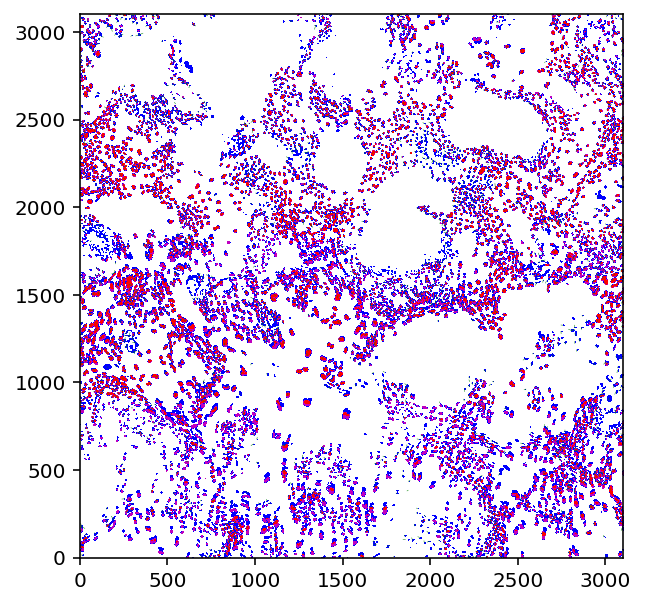

In [ ]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
im = comp #plt.imread(path_to_output + '/' + sample_name_with_block + '/Composite.png')
ax1.imshow(im, origin = 'lower', cmap = clrs.ListedColormap(['w', 'b', 'm', 'r']))
#ax1.scatter(connections.tl_x, connections.tl_y, s=0.1, c='g', marker="s", label='timelapse')

# lc = mc.LineCollection(lines, linewidths=1, color = 'g')
# ax1.add_collection(lc)
for i in range(0, len(connections.hcr_x)):
  ax1.plot([connections.hcr_x[i], connections.tl_x[i]], [connections.hcr_y[i], connections.tl_y[i]], 'g', linewidth = 0.25)

# plt.show()
# mpld3.display()
plt.savefig(path_to_output + '/' + sample_name_with_block + '/' + "connections.png", dpi = 1000)